# Heritabiltiy from family data. 
This notebook follows the GCTA-based practical exercise with R, as described in the provided instructions.

 In this exercise you will be carrying out association analysis of data from a mini genome-wide association study. The data comes from families (related individuals) measured for a quantitative trait of interest. The purpose is detect which (if any) of the loci are associated with the quantitative trait. 

 We will be using family data consisting of 498 individuals typed at 134,946 SNPs. All individuals have measurements of a quantitative trait of interest. You can assume that appropriate quality control (QC) checks on SNPs and individuals have been carried out prior to the current analysis i.e. the data set is already QC-ed. 


## setup environment

In [1]:
# shared tools and data folder
source /home/student/USER/miniconda.sh
conda activate anders
TOOL_PATH=/home/student/opt/anders # for standalone tool script including java package
SHARED_PATH=/home/tch_wyd/myname/shared # For reference database
INPUT_PATH=/home/tch_wyd/myname/inputs/heritability

(base) (anders) (anders) (anders) (anders) 


In [2]:
mkdir -p ~/sysu_day5_heritabiltiy
cd ~/sysu_day5_heritabiltiy

cp -sf ${INPUT_PATH}/quantfam.zip .
cp -sf ${SHARED_PATH}/online.R .
cp -sf /home/tch_myname/heritability_data/heritability_quiz*.json ./

if [ ! -s quantfamdata.bed ]; then unzip -o quantfam.zip; fi

echo -----files in folder -----

ls


(anders) (anders) (anders) (anders) (anders) (anders) (anders) Archive:  quantfam.zip
  inflating: multipleGRMs6andnot6.txt  
  inflating: multipleGRMsnot6.txt    
  inflating: multipleGRMs.txt        
  inflating: myphenos.txt            
  inflating: quantfamdata.fam        
  inflating: quantfamdata.bim        
  inflating: quantfamdata.bed        
  inflating: manifest.csv            
(anders) (anders) -----files in folder -----
(anders) (anders) heritability_quiz1.json   multipleGRMs.txt  quantfamdata.bim
manifest.csv              myphenos.txt      quantfamdata.fam
multipleGRMs6andnot6.txt  online.R          quantfam.zip
multipleGRMsnot6.txt      quantfamdata.bed
(anders) 


In [3]:
# set up R working space
work_d <- path.expand("~/sysu_day5_heritabiltiy")
setwd(work_d)

# Import some functions to help in visualization
source("/home/tch_wyd/myname/shared/visFuns.R")
source("/home/tch_wyd/myname/shared/newPlotPlink.R")

In [10]:
# set up python working space
import os
work_d = os.path.expanduser("~/sysu_day5_heritabiltiy")
os.chdir(work_d)

You should find 3 PLINK binary-format files in your directory: quantfamdata.bed, quantfamdata.bim and quantfamdata.fam. The file quantfamdata.bed is the binary genotype file which will not be human readable. The file quantfamdata.bim is a map file. You can take a look at this (e.g. by typing more quantfamdata.bim). The file quantfamdata.fam gives the pedigree structure in a format that is compatible with the binary genotype file. You can take a look at this (e.g. by typing more quantfamdata.fam). Note this file is the same as the first six columns of a standard pedigree file, with the last column giving each individual's quantitative trait value.



## Step 1: Create phenotype file in R

To start with, we will use R to create the phenotype file required by GCTA.

In [5]:
head ./myphenos.txt

100001 4 133.28
100001 5 120.952
100001 11 116.551
100001 14 153.177
100001 17 126.523
100002 19 137.761
100002 22 133.779
100002 24 117.224
100003 26 132.029
100004 29 117.891
(anders) 


- which columns has the phenotype height?

In [6]:
fam <- setNames(read.table("./quantfamdata.fam", header=FALSE), c("FID", "IID", "IID_of_father", "IID_of_mother", "Sex", "Phenotype_height"))
pheno <- setNames(data.frame(fam[,1:2], fam[,6]), c("FID", "IID", "Phenotype_height"))
write.table(pheno, file="./myphenos.txt", col.names=FALSE, row.names=FALSE, quote=FALSE)

cat("\nfam file\n")
head(fam)

cat("\nphnotype file\n")
head(pheno)



fam file


,FID,IID,IID_of_father,IID_of_mother,Sex,Phenotype_height
,<int>,<int>,<int>,<int>,<int>,<dbl>
1,100001,4,10014,20013,1,133.280
2,100001,5,10017,20016,2,120.952
3,100001,11,3,20527,1,116.551
4,100001,14,2,20001,2,153.177
5,100001,17,16,10,2,126.523
6,100002,19,0,0,2,137.761



phnotype file


,FID,IID,Phenotype_height
,<int>,<int>,<dbl>
1,100001,4,133.280
2,100001,5,120.952
3,100001,11,116.551
4,100001,14,153.177
5,100001,17,126.523
6,100002,19,137.761


Male have value 1 and female have a value of 2. 

- which of the  indivuduals has no parents in the data?

In [11]:
echo -- number of lines in bim file --
wc -l ./quantfamdata.bim

echo -e "\n-- first 10 lines bim file --"
echo -e "CHR\tvariantID CM\tPosition \tallele_1\t allele_2"
head blue_./quantfamdata.bim

echo -e "\n-- counts number of variants per chromosone from the first column of bim file --"
echo \#Var Chromosome_name
cat ./quantfamdata.bim | cut -f1  | uniq -c


-- number of lines in bim file --
(anders) 134946 ./quantfamdata.bim
(anders) (anders) 
-- first 10 lines bim file --
(anders) CHR	variantID CM	Position 	allele_1	 allele_2
(anders) head: 无法打开'blue_./quantfamdata.bim' 读取数据: No such file or directory
(anders) (anders) 
-- counts number of variants per chromosone from the first column of bim file --
(anders) #Var Chromosome_name
(anders)    9003 1
   9721 2
   8040 3
   7734 4
   7263 5
  19811 6
   6255 7
   5849 8
   4531 9
   5331 10
   5401 11
  18385 12
   3984 13
   3613 14
   3215 15
   3050 16
   3114 17
   3100 18
   2288 19
   2472 20
   1402 21
   1384 22
(anders) 


In [11]:

from jupyterquiz import display_quiz
display_quiz('heritability_quiz1.json')


<IPython.core.display.Javascript object>

## Step 2: GCTA Analysis
Perform association analysis accounting for relatedness using GCTA. Plink cannot handle family and uses PC to control for population structure. GCTA can handle both by using the GRM directly in the model and the GRM has information about both the population structure and relatedness. 

In [12]:

## 1.5 min to run
gcta64 --mlma --bfile quantfamdata --threads 2 --pheno myphenos.txt --out GCTAresults

## we can also copy the results, if it takes longer than 3 min
## You might have to add a "#" to the first command line, remove the "#" before the next line, and restart the kernel, rerun 
# cp /home/tch_myname/sysu_day5_heritabiltiy/GCTAresults.log /home/tch_hemyname/sysu_day5_heritabiltiy/GCTAresults.mlma ./

(anders) *******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 15:11:57 CST on Thu Jul 24 2025.
Hostname: a6000-gpu1

Accepted options:
--mlma 
--bfile quantfamdata
--threads 2
--pheno myphenos.txt
--out GCTAresults

Note: the program will be running on 2 threads.

Reading PLINK FAM file from [quantfamdata.fam].
498 individuals to be included from [quantfamdata.fam].
Reading PLINK BIM file from [quantfamdata.bim].
134946 SNPs to be included from [quantfamdata.bim].
Reading PLINK BED file from [quantfamdata.bed] in SNP-major format ...
Genotype data for 498 individuals and 134946 SNPs to be included from [quantfamdata.bed].
Reading phenotypes from [myphen

### Load and visualize results in R

In [13]:

res <- read.table("./GCTAresults.mlma", header=TRUE)
head(res)



,Chr,SNP,bp,A1,A2,Freq,b,se,p
,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,rs9326624,558615,G,A,0.0913655,0.693811,0.924665,0.453052
2,1,rs3094315,742429,G,A,0.3162650,0.494021,0.550792,0.369758
3,1,rs12562034,758311,A,G,0.0818182,0.827582,0.882891,0.348576
4,1,rs3934834,995669,A,G,0.1817270,-0.121518,0.640661,0.849563
5,1,rs3737728,1011278,A,G,0.1957830,0.513895,0.644486,0.425236
6,1,rs4970405,1038818,G,A,0.1194780,-0.697621,0.764350,0.361401


- identify the p-value, the effect size and the allele frequency
Lets plot the results in a manhattan plot

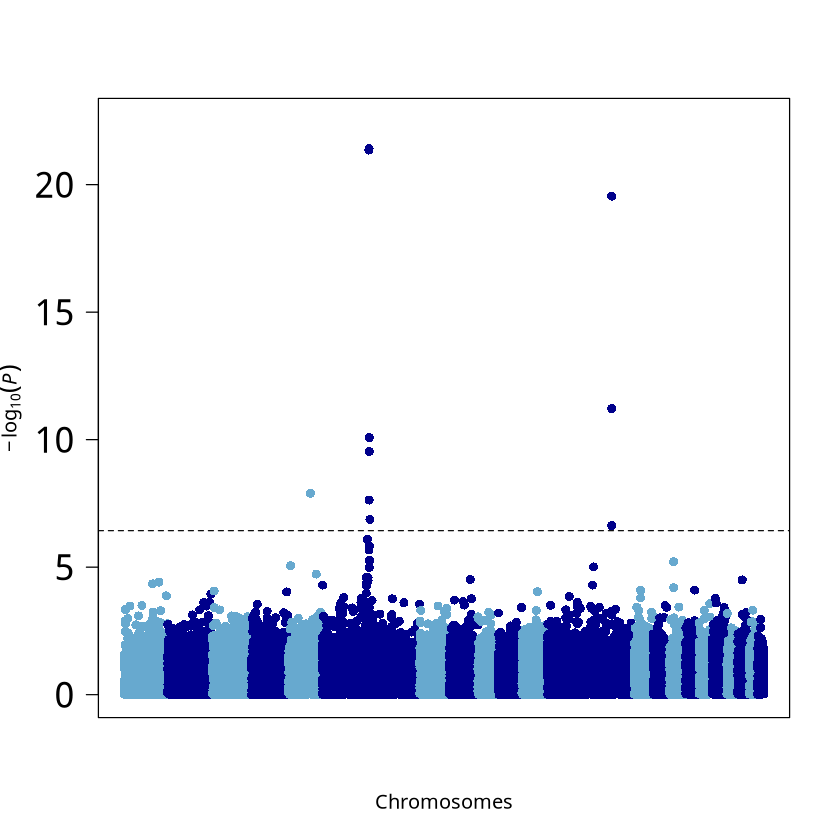

In [14]:
manPlot(res$p,chr=res$Chr,)

 - how many genome wide significant association signals?

Lets evaluation whether GCTA was able to accomidate the family structure or whether it give inflated test statistics. 


Inflation factor (lamdda)= 0.9892948

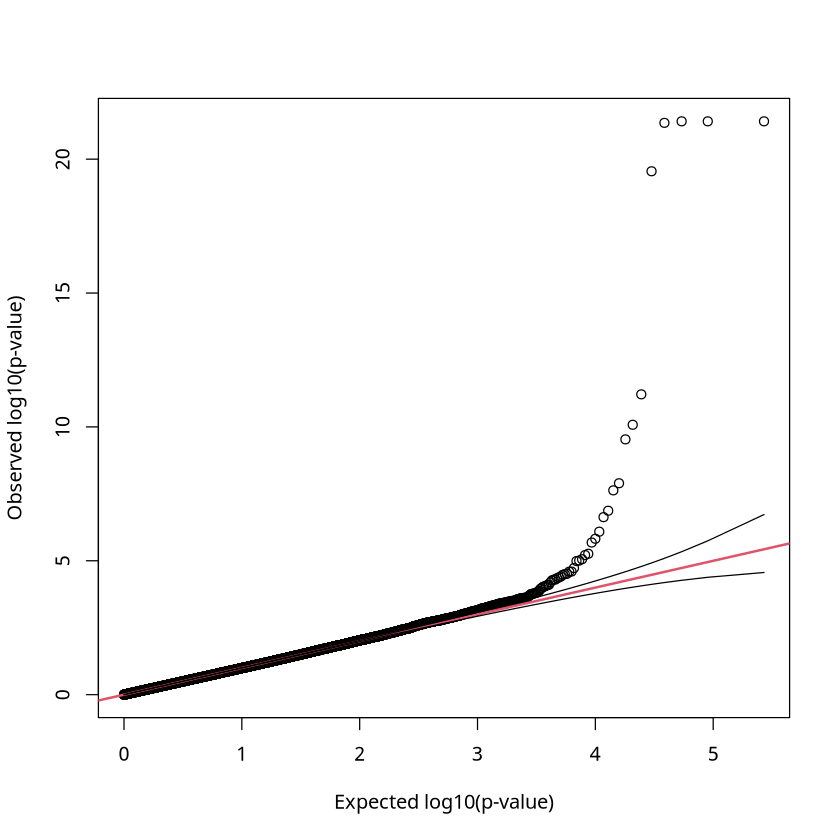

In [16]:
qqp(res$p)

chi <- qchisq(res$p, 1,lower.tail=FALSE)
lambda <- median(chi) / qchisq(0.5,1)
cat("\nInflation factor (lamdda)=",lambda)

- do you see any signs of inflation?

### Estimate SNP Heritability with GCTA


To use GCTA to estimate the heritability accounted for by all autosomal
genome-wide SNPs, you need to first estimate the GRM, and then use the
GRM to estimate the (SNP) heritability. This can be achieved using the
following commands:

In [73]:

gcta64 --bfile quantfamdata --autosome --make-grm-bin --threads 1 --out GCTAgrm


*******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 11:35:40 CST on Fri Jul 25 2025.
Hostname: a6000-gpu1

Error: --bfile quantfamdata.fam not found
An error occurs, please check the options or data
(anders) 


The GRM contains information about both family and population structure. If there is no population structure then the GRM is the kinship coefficient. Lets identify (genetically) unrelated individuals from the GRM

In [18]:
gcta64 --grm GCTAgrm --grm-singleton 0.05 --threads 1 --out unrelated

*******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 15:23:24 CST on Thu Jul 24 2025.
Hostname: a6000-gpu1

Options: 
 
--grm GCTAgrm 
--grm-singleton 0.05 
--threads 1 
--out unrelated 

The program will be running with up to 1 threads.
Pruning the GRM with a cutoff of 0.050000...
Total number of parts to be processed: 1
    Processing part 1
Related family pairs have been saved to unrelated.family.txt
After pruning the GRM, there are 313 individuals (185 individuals removed).
    Pruned singleton IDs have been saved to unrelated.singleton.txt

Analysis finished at 15:23:24 CST on Thu Jul 24 2025
Overall computational time: 0.00 sec.
(anders) 


- How many individuals are unrelated in this sample? GRM cut-off 0.05? cut-off 0.025?

    
    
    
   #### estimate heritabilty

In [19]:

gcta64 --reml --grm-bin GCTAgrm --pheno myphenos.txt --threads 2 --out GCTAherit


*******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 15:24:01 CST on Thu Jul 24 2025.
Hostname: a6000-gpu1

Accepted options:
--reml
--grm-bin GCTAgrm
--pheno myphenos.txt
--threads 2
--out GCTAherit

Note: the program will be running on 2 threads.

Reading IDs of the GRM from [GCTAgrm.grm.id].
498 IDs are read from [GCTAgrm.grm.id].
Reading the GRM from [GCTAgrm.grm.bin].
GRM for 498 individuals are included from [GCTAgrm.grm.bin].
Reading phenotypes from [myphenos.txt].
Non-missing phenotypes of 498 individuals are included from [myphenos.txt].

498 individuals are in common in these files.

Performing  REML analysis ... (Note: may take hours dependin

# Error. Ignore the line below

In [35]:
gcta64 --reml --grm-bin GCTAgrm --pheno myphenos.txt --threads 2 --out GCTAherit --covar sex


*******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 17:27:52 CST on Thu Jul 24 2025.
Hostname: a6000-gpu1

Accepted options:
--reml
--grm-bin GCTAgrm
--pheno myphenos.txt
--threads 2
--out GCTAherit
Error: 
  invalid option "--cov".

An error occurs, please check the options or data
(anders) 



The screen output estimates the SNP heritability **V(G)/Vp to be 0.480590** or around 48%.

 - Can you find the value is the log content above ?
 - What is the total varitablity?
 





### Estimate Heritability for Individual Chromosomes
To estimate the heritabilty accounted for by SNPs on chromosomes 1, 2, 6 and
12 (for example), use the following commands:

In [23]:

gcta64 --bfile quantfamdata --chr 1 --make-grm-bin --out GCTAgrmchr1
gcta64 --reml --grm-bin GCTAgrmchr1 --pheno myphenos.txt --out GCTAheritchr1

gcta64 --bfile quantfamdata --chr 2 --make-grm-bin --out GCTAgrmchr2
gcta64 --reml --grm-bin GCTAgrmchr2 --pheno myphenos.txt --out GCTAheritchr2

gcta64 --bfile quantfamdata --chr 6 --make-grm-bin --out GCTAgrmchr6
gcta64 --reml --grm-bin GCTAgrmchr6 --pheno myphenos.txt --out GCTAheritchr6

gcta64 --bfile quantfamdata --chr 12 --make-grm-bin --out GCTAgrmchr12
gcta64 --reml --grm-bin GCTAgrmchr12 --pheno myphenos.txt --out GCTAheritchr12


*******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 15:27:16 CST on Thu Jul 24 2025.
Hostname: a6000-gpu1

Accepted options:
--bfile quantfamdata
--chr 1
--make-grm-bin
--out GCTAgrmchr1

Note: This is a multi-thread program. You could specify the number of threads by the --thread-num option to speed up the computation if there are multiple processors in your machine.

Reading PLINK FAM file from [quantfamdata.fam].
498 individuals to be included from [quantfamdata.fam].
Reading PLINK BIM file from [quantfamdata.bim].
134946 SNPs to be included from [quantfamdata.bim].
9003 SNPs on chromosome 1 are included in the analysis.
Reading PLINK BED file from 


You should find that the SNP heritabilities on chromosomes 1 and 2 do not look
particularly significant (given the estimated standard errors), but the SNP
heritabilities on chromosomes 6 and 12 are significant (as might be expected
from the strong effects seen on these chromosomes).
The sum of the SNP heritabilities on these 4 chromosomes
(0.206479+0.111512+0.368184+0.286570) adds up to more then the overall
SNP heritability of 0.480589. This is due to the phenomenon that, in the
presence of population substructure or close relatedness, chromosome-
specific heritability estimates can be confounded by shared non-genetic effects
(for examples shared environment) or corrrelations between SNPs on different
chromosomes, leading to an over-estimate of the chromosome-specific
heritability.



# Heritability of ukbiobank 10k Europeans (white ethnic groups)


Now we want to look at the overall heritability of unrelated individuals. Unrelated individuals can be used to estimate the co-called SNP heritability which is the variance that can be explained by the genetic data. Note that this can be ower that the actual heritability which is estimated for family data. 
We will use the individual data from UKBioBank, which were used for GWAS exercise.

There are four steps of the analysis:

1. We should estimate the GRM (genetic relationship matrix) first to capture the cryptic relatedness among individuals.
2. Then we want to remove related individuals, keep only the "singleton" individuals.
3. For the next, we have to re-estimate the GRM using singleton data. As GRM is required for accurate heritability estimation.
4. Finally we do heritability estimation.

We will use the height data as the quantative phenotype.


In [31]:
cd ~/sysu_day5_heritabiltiy

cp -sf /home/tch_myname/heritability_data/European_1w_QC.white* ./
cp -sf /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt ./
cp -sf /home/student/USER/GWAS/data/European_1w_QC_PC20.assoc.linear ./

EU_WHITE_BFILE=./European_1w_QC.white
PHENOS=./European_1w_phenotypes.white.txt

# Columns: eid     Standing_height Sex     Age_at_recruitment      Body_mass_index 
# Townsend_deprivation_index_at_recruitment       Ethnic_background       Smoking_status  Alcohol_intake_frequency     
# Genotype_measurement_batch       Country_of_birth


(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) 


---------------------------------------
Let's first review the GWAS analysis results of height data:

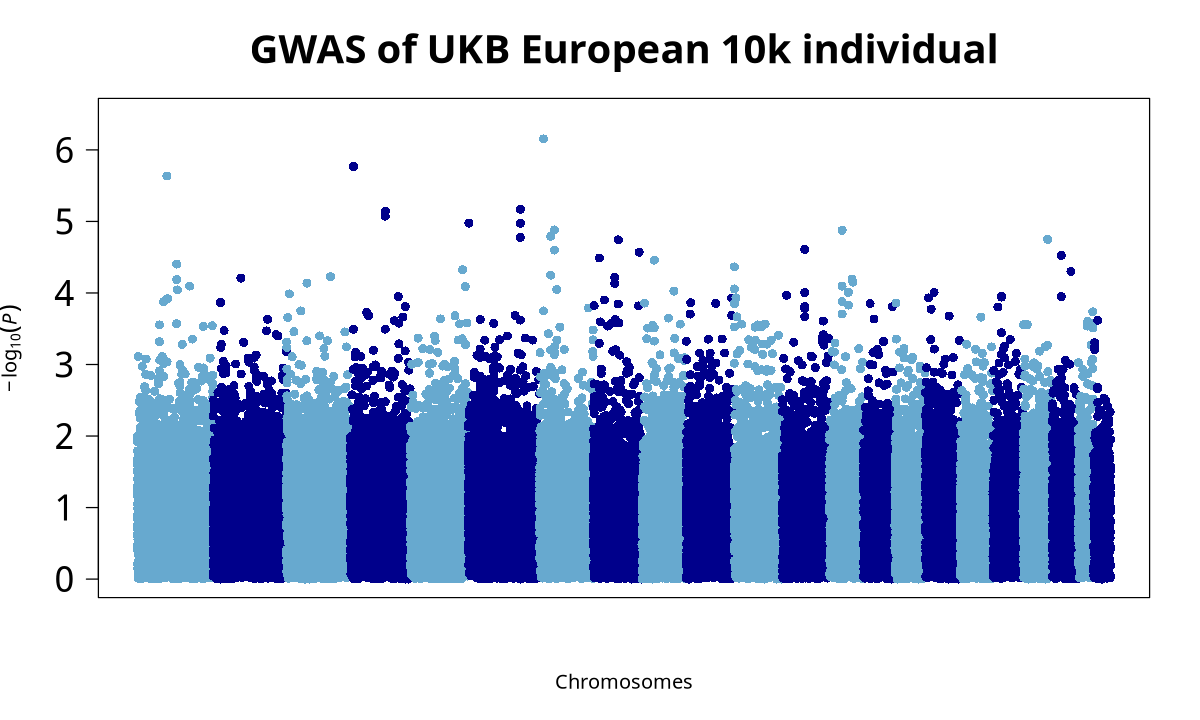

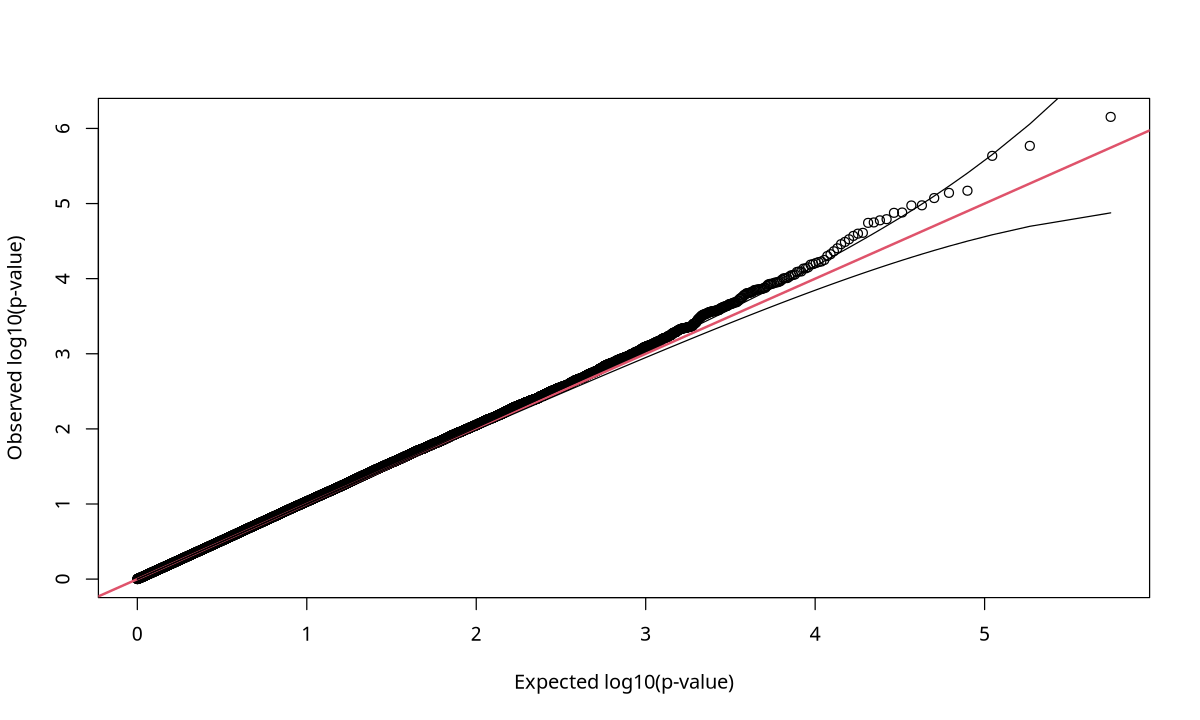

In [33]:

library(data.table)
source("./online.R")
options(repr.plot.width = 10, repr.plot.height = 6)
data <- fread("./European_1w_QC_PC20.assoc.linear", header=TRUE, stringsAsFactors=FALSE, data.table=FALSE)
manPlot(data$P,chr=as.integer(data$CHR),cap = 10^-30,main="GWAS of UKB European 10k individual")
qqp(data$P)

And let's check the number of variants and individual samples.

In [ ]:
wc -l European_1w_QC.white.bim
wc -l European_1w_QC.white.fam


#### Step 1. estimation of GRM

Because it takes a bit too long to calculate the GRM, we can just copy the pre-made results.

Then we can take a look at the log file to see what's happening.

In [37]:
## estimate GRM 
#gcta64 --bfile ${EU_WHITE_BFILE} --autosome --make-grm-bin --threads 2 --out EU_White_QC.gcta_grm

## Because it takes a bit too long for thousands of individuals, we just copy the results
## You could uncomment the "gcta64" line above, and run it if you want to try
cp -sf /home/tch_myname/sysu_day5_heritabiltiy/EU_White_QC.gcta_grm* ./

cat /home/tch_myname/sysu_day5_heritabiltiy/EU_White_QC.gcta_grm.log


(anders) (anders) (anders) (anders) (anders) (anders) (anders) *******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 10:16:16 CST on Thu Jul 24 2025.
Hostname: a6000-gpu1

Accepted options:
--bfile ./European_1w_QC.white
--autosome
--make-grm-bin
--threads 2
--out EU_White_QC.gcta_grm

Note: the program will be running on 2 threads.

Reading PLINK FAM file from [./European_1w_QC.white.fam].
7489 individuals to be included from [./European_1w_QC.white.fam].
Reading PLINK BIM file from [./European_1w_QC.white.bim].
272081 SNPs to be included from [./European_1w_QC.white.bim].
272081 SNPs from chromosome 1 to chromosome 22 are included in the analysis.
Read

#### Step 2. find those related/unrelated individuals

In [39]:

# check relatedness using GRM
gcta64 --grm EU_White_QC.gcta_grm --grm-singleton 0.05 --threads 2 --out EU_White_QC.gcta_unrelated


(anders) *******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 17:29:32 CST on Thu Jul 24 2025.
Hostname: a6000-gpu1

Options: 
 
--grm EU_White_QC.gcta_grm 
--grm-singleton 0.05 
--threads 2 
--out EU_White_QC.gcta_unrelated 

The program will be running with up to 2 threads.
Pruning the GRM with a cutoff of 0.050000...
Total number of parts to be processed: 2
    Processing part 1
Related family pairs have been saved to EU_White_QC.gcta_unrelated.family.txt
After pruning the GRM, there are 7355 individuals (134 individuals removed).
    Pruned singleton IDs have been saved to EU_White_QC.gcta_unrelated.singleton.txt

Analysis finished at 17:29:32 CST o

- how many individuals were related with a kinship coefficient above 0.05? 

#### Step 3. Re-estimate the GRM using unrelated (singleton) individuals

Again, this might take several minutes to run. So we just copy the results, and show the running log.

In [40]:

## remove related ones and make new grm
#gcta64 --bfile ${EU_WHITE_BFILE} --keep EU_White_QC.gcta_unrelated.singleton.txt --autosome --make-grm-bin --threads 2 --out EU_White_QC.gcta_singleton_grm

## or you can copy the results
cp -sf /home/tch_myname/sysu_day5_heritabiltiy/EU_White_QC.gcta_singleton_grm* ./

cat EU_White_QC.gcta_singleton_grm.log

(anders) (anders) (anders) (anders) (anders) (anders) *******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 10:24:17 CST on Thu Jul 24 2025.
Hostname: a6000-gpu1

Accepted options:
--bfile ./European_1w_QC.white
--keep EU_White_QC.gcta_unrelated.singleton.txt
--autosome
--make-grm-bin
--threads 2
--out EU_White_QC.gcta_singleton_grm

Note: the program will be running on 2 threads.

Reading PLINK FAM file from [./European_1w_QC.white.fam].
7489 individuals to be included from [./European_1w_QC.white.fam].
7355 individuals are kept from [EU_White_QC.gcta_unrelated.singleton.txt].
Reading PLINK BIM file from [./European_1w_QC.white.bim].
272081 SNPs to be i

#### Step4. Calculate the heritability

Again, it might take long to run the calculation, so we just copy the results and show the log.

Because age and sex can have effect on height, so we use sex and age data as covariates.

In [48]:

# /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt

awk -F "\t" '{print $1"\t"$1"\t"$2}' /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt > EU_1w_pheno.white.height.txt
awk -F "\t" '{print $1"\t"$1"\t"$3}' /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt > EU_1w_pheno.white.sex.txt
awk -F "\t" '{print $1"\t"$1"\t"$4}' /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt > EU_1w_pheno.white.age.txt

## estimate heritability 
#gcta64 --reml --grm-bin EU_White_QC.gcta_singleton_grm \
#    --pheno EU_1w_pheno.white.height.txt --covar EU_1w_pheno.white.sex.txt --qcovar EU_1w_pheno.white.age.txt \
#    --threads 16 --out EU_White_QC.gcta_singleton.reml_height

## we just copy the results and show the log
cp /home/tch_myname/sysu_day5_heritabiltiy/EU_White_QC.gcta_singleton.reml_height* ./
cat EU_White_QC.gcta_singleton.reml_height.log


(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) *******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 18:10:00 CST on Wed Jul 23 2025.
Hostname: a6000-gpu1

Accepted options:
--reml
--grm-bin EU_White_QC.gcta_singleton_grm
--pheno EU_1w_pheno.white.height.txt
--covar EU_1w_pheno.white.sex.txt
--qcovar EU_1w_pheno.white.age.txt
--threads 16
--out EU_White_QC.gcta_singleton.reml_height

Note: the program will be running on 16 threads.

Reading IDs of the GRM from [EU_White_QC.gcta_singleton_grm.grm.id].
7355 IDs are read from [EU_White_QC.gcta_singleton_grm.grm.id].
Reading the GRM from [

- how large is the estimated SNP heritabilty?
- is it signicantly different than zero?

#### bonus Step. heritability on BMI

In [42]:
We actually also have BMI data, which can be used for heritability estimation.b

bash: We: 未找到命令...
(anders) 


In [49]:
# European_1w_phenotypes.white.txt

awk -F "\t" '{print $1"\t"$1"\t"$5}' /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt > EU_1w_pheno.white.bmi.txt
awk -F "\t" '{print $1"\t"$1"\t"$3}' /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt > EU_1w_pheno.white.sex.txt
awk -F "\t" '{print $1"\t"$1"\t"$4}' /home/tch_myname/heritability_data/European_1w_phenotypes.white.txt > EU_1w_pheno.white.age.txt

## estimate heritability 
#gcta64 --reml --grm-bin EU_White_QC.gcta_singleton_grm \
#    --pheno EU_1w_pheno.white.bmi.txt --covar EU_1w_pheno.white.sex.txt --qcovar EU_1w_pheno.white.age.txt \
#    --threads 16 --out EU_White_QC.gcta_singleton.reml_bmi

cp /home/tch_myname/sysu_day5_heritabiltiy/EU_White_QC.gcta_singleton.reml_bmi* ./
cat EU_White_QC.gcta_singleton.reml_bmi.log

(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) *******************************************************************
* GCTA (Genome-wide Complex Trait Analysis)
* Version v1.94.1 Linux
* Built at Jan 16 2024 14:19:02, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang jian.yang@westlake.edu.cn
* MIT License
*******************************************************************
Analysis started at 18:29:00 CST on Wed Jul 23 2025.
Hostname: a6000-gpu1

Accepted options:
--reml
--grm-bin EU_White_QC.gcta_singleton_grm
--pheno EU_1w_pheno.white.bmi.txt
--covar EU_1w_pheno.white.sex.txt
--qcovar EU_1w_pheno.white.age.txt
--threads 16
--out EU_White_QC.gcta_singleton.reml_bmi

Note: the program will be running on 16 threads.

Reading IDs of the GRM from [EU_White_QC.gcta_singleton_grm.grm.id].
7355 IDs are read from [EU_White_QC.gcta_singleton_grm.grm.id].
Reading the GRM from [EU_White_QC.gct

 - what is the estimated SNP heritabilty
 - is it higher or lower than for height?
 - if you have family data would you expect the heritabilty to be higher or lower？
   
Congrats, you have finished the exercise for heritability estimation using genotype data.

Let's now do exercise for LDSC estimation, which is an alternative method to estimate heritability.


# LD socre regression by LDSC

In this tutorial is based on https://cloufield.github.io/GWASTutorial/08_LDSC/. We will use sample summary statistics for HDLC and 
LDLC from Japan Biobank (JBB). 
- Kanai, Masahiro, et al. "Genetic analysis of quantitative traits in 
the Japanese population links cell types to complex human diseases." 
Nature genetics 50.3 (2018): 390-400.

### LDSC: LD Score Regression

LDSC is one of the most commonly used command-line tools to estimate:

- **Inflation** ($\lambda$) in test statistics  
- **SNP-heritability**  
- **Genetic correlation** between traits  
- **Enrichment** in specific cell or tissue types

Unlike GCTA is it based on **GWAS summary statistics** and not individual-level genotype data.

---

#### Linkage Disequilibrium (LD)

LDSC is based on **Linkage disequilibrium (LD)** which is the non-random association of alleles at different loci in a given population.  
> In other words, if you know the allele at SNP A, you can better predict the allele at SNP B.

LD is typically quantified by the squared correlation coefficient between SNPs ($r_{jk}^2$) for SNP j and SNP k, or the covariance ($D_{jk}$).

---

####  LD Score

The **LD score** of a SNP $j$ is defined as:

$$
\text{LD Score}_j = \sum_{k} r_{jk}^2
$$

Where:
- $r_{jk}^2$ is the squared correlation (LD) between SNP $j$ and SNP $k$
- The sum is typically over all SNPs within a 1 cM or 1 Mb window of SNP $j$

**Interpretation:** A SNP that is in high LD with many other SNPs (i.e., tags more variants) has a higher LD score.

---

####  LD Score Regression

**Key Idea:** A SNP will tend to have a higher test statistic if it is in LD with one or more causal variants.  
The expected chi-squared statistic at SNP $j$, assuming polygenicity, follows:

$$
\mathbb{E}[\chi_j^2] = 1 + \frac{N h^2}{M} \cdot \text{LD Score}_j + a
$$

Where:
- $\chi_j^2$: chi-squared statistic for SNP $j$
- $N$: GWAS sample size
- $M$: total number of SNPs analyzed
- $h^2$: SNP heritability (on the observed scale)
- $a$: contribution from confounding bias (e.g., cryptic relatedness, population stratification)

**This is the key regression equation used in LDSC:**
- Regress $\chi^2$ on LD score
- The **slope** gives $\frac{N h^2}{M}$
- The **intercept** estimates inflation ($a$) due to confounding plus 1. If the intercept is close to 1 then it means that there is no confounding and thus any inflation of p-values is due to the trait being highly polygenic



### Set the enviroment for running analysis

In [2]:

# shared tools and data folder
source /home/student/USER/miniconda.sh
conda activate anders
TOOL_PATH=/home/student/opt/anders # for standalone tool script including java package
SHARED_PATH=/home/tch_wyd/myname/shared # For reference database
INPUT_PATH=/home/tch_wyd/myname/inputs/ldsc  # for input data


(base) (anders) (anders) (anders) (anders) 


In [3]:

LDSC_ENV="/home/student/miniconda3/bin/conda run -p /home/student/miniconda3/envs/ldsc_env"
LDSC_MUNGE="${LDSC_ENV} /home/student/ldsc/munge_sumstats.py"
LDSC="${LDSC_ENV} /home/student/ldsc/ldsc.py"


(anders) (anders) (anders) 


Make a folder and copy the data to you folder. 

In [52]:

mkdir -p ~/sysu_day5_ldscore
cd ~/sysu_day5_ldscore

cp ${INPUT_PATH}/BBJ*.gz ./
cp ${INPUT_PATH}/w_hm3.snplist ./
ln -sf ${INPUT_PATH}/eas_ldscores ./
cp -sf ${SHARED_PATH}/online.R ./
cp -sf ${SHARED_PATH}/visFuns.R ./
cp -sf ${SHARED_PATH}/newPlotPlink.R ./

cp -sf /home/tch_myname/heritability_data/quiz_ldscore.json ./

ls ./


(anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) (anders) BBJ_HDLC.sumstats.gz  BBJ_LDLC.txt.gz  online.R           w_hm3.snplist
BBJ_HDLC.txt.gz       eas_ldscores     quiz_ldscore.json
BBJ_LDLC.sumstats.gz  newPlotPlink.R   visFuns.R
(anders) 


In [6]:


# set up R working space
work_d <- path.expand("~/sysu_day5_ldscore")
setwd(work_d)


geneticMap <- "/home/tch_wyd/myname/shared/locuszoom_ref/hg19/genetic_map_GRCh37_chr"
refGenes <- "/home/tch_wyd/myname/shared/locuszoom_ref/refGeneHG19.gz"

# Import some functions to help in visualization
source("./visFuns.R")
source("./newPlotPlink.R")


In [7]:

# set up python working space
import os
work_d = os.path.expanduser("~/sysu_day5_ldscore")
os.chdir(work_d)


The **txt.gz** contains the GWAS summary statistics for cholesterol measurements LDL and HDL. LDL is a risk biomarker for cardiovascular diseases while HDL is correlated with reduced risk of cardiovascular disease. The folder **eas_ldscores** containts precalulated LD between SNPs in the east asian populatoin. 

### Exploring the summary statistics

Let us explore the summary statistics from the GWAS study. First lets look at the number of lines in the files


In [55]:

echo number of lines for HDLC:
zcat BBJ_HDLC.txt.gz | wc -l

echo number of lines for LDLC:
zcat BBJ_LDLC.txt.gz | wc -l


number of lines for HDLC:
(anders) 5961601
(anders) (anders) number of lines for LDLC:
(anders) 5961601
(anders) 


Lets look at the first 10 lines of the GWAS summary statistics for HDLC

In [56]:
zcat BBJ_HDLC.txt.gz |head -n 10 | column -t

SNP          CHR  POS     REF  ALT  Frq     Rsq    BETA       SE        P       LOG10P  N
rs143225517  1    751756  T    C    0.1517  0.951  0.005397   0.007436  0.468   0.3298  70657
rs3094315    1    752566  G    A    0.8438  0.986  -0.005241  0.007217  0.4677  0.33    70657
rs61770173   1    753405  C    A    0.8385  0.832  -0.005624  0.007752  0.4681  0.3297  70657
rs117086422  1    845635  C    T    0.1402  0.869  0.004849   0.008072  0.548   0.2612  70657
rs28612348   1    846078  C    T    0.1419  0.858  0.004844   0.00808   0.5488  0.2606  70657
rs4475691    1    846808  C    T    0.1411  0.998  0.004449   0.007507  0.5534  0.257   70657
rs950122     1    846864  G    C    0.1411  0.998  0.004449   0.007508  0.5534  0.257   70657
rs3905286    1    847228  C    T    0.1391  0.986  0.004522   0.007595  0.5516  0.2584  70657
rs28407778   1    847491  G    A    0.1394  0.985  0.004552   0.007598  0.5491  0.2603  70657

gzip: stdout: Broken pipe
(anders) 


In [8]:


# run to start quiz       
from jupyterquiz import display_quiz
display_quiz('quiz_ldscore.json')


<IPython.core.display.Javascript object>

### visualize the summery stats

Before we perform the LD score regression we visualize the results using R

In [58]:

#load package for fast reading of data
suppressWarnings(require(data.table))
suppressWarnings(require(R.utils))
## read positions (hg38)
data <- fread("./BBJ_HDLC.txt.gz", sep="\t", header=TRUE, stringsAsFactors=FALSE, data.table=FALSE)

#print the first 6 lines
head(data)


载入需要的程序包：R.utils

载入需要的程序包：R.oo

载入需要的程序包：R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


载入程序包：‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


载入程序包：‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings




,SNP,CHR,POS,REF,ALT,Frq,Rsq,BETA,SE,P,LOG10P,N
,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,rs143225517,1,751756,T,C,0.1517,0.951,0.005397,0.007436,0.4680,0.3298,70657
2,rs3094315,1,752566,G,A,0.8438,0.986,-0.005241,0.007217,0.4677,0.3300,70657
3,rs61770173,1,753405,C,A,0.8385,0.832,-0.005624,0.007752,0.4681,0.3297,70657
4,rs117086422,1,845635,C,T,0.1402,0.869,0.004849,0.008072,0.5480,0.2612,70657
5,rs28612348,1,846078,C,T,0.1419,0.858,0.004844,0.008080,0.5488,0.2606,70657
6,rs4475691,1,846808,C,T,0.1411,0.998,0.004449,0.007507,0.5534,0.2570,70657


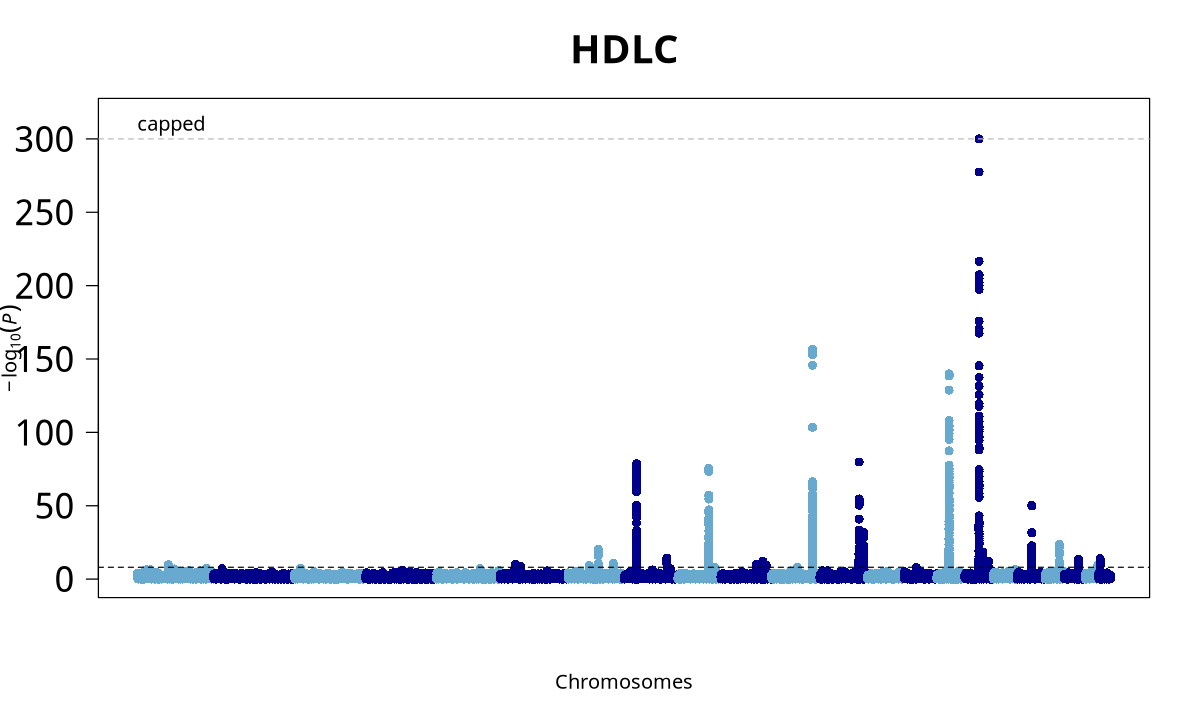

In [59]:

source("./online.R")
options(repr.plot.width = 10, repr.plot.height = 6)
manPlot(data$P,chr=as.integer(data$CHR),cap = 10^-300,main="HDLC")


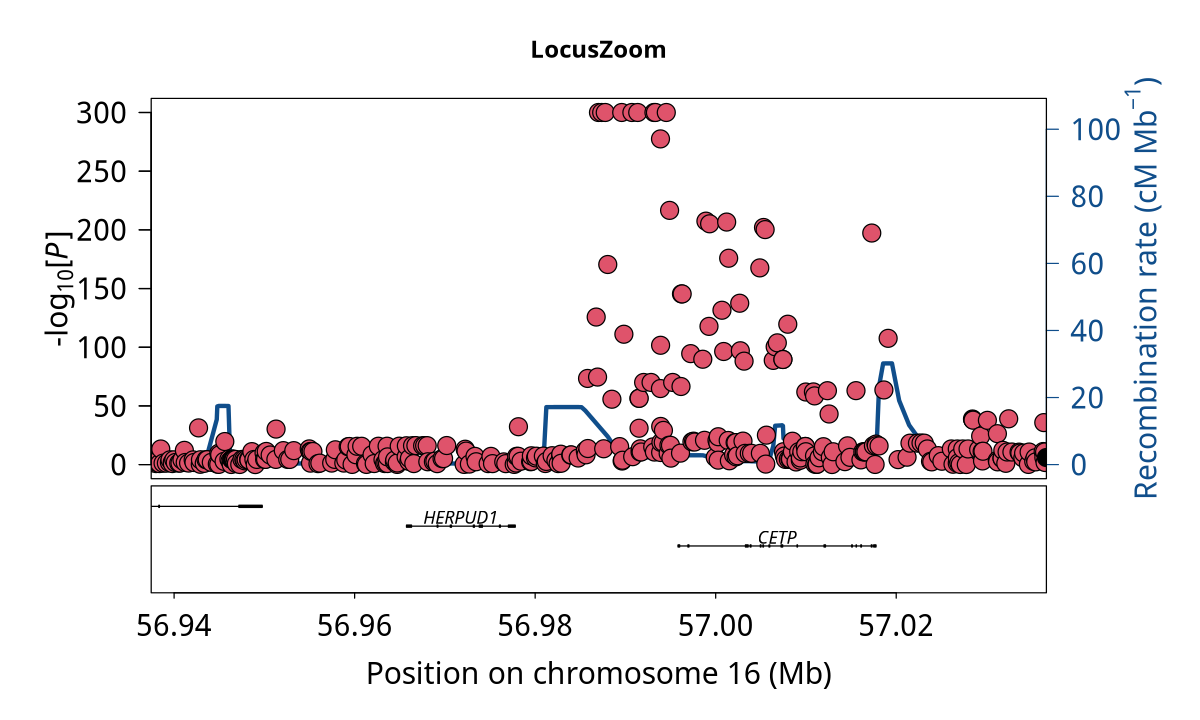

In [60]:
w <- which.min(data$P)
pos <- data$POS[w]
chr <- data$CHR[w]

win <- 5e4
region <- subset(data,CHR==chr & POS > pos-win &  POS < pos+win)

#truncate p-value
region$P <- pmax(10^-300,region$P)
source("./newPlotPlink.R")

#geneticMap <- "/home/tch_wyd/myname/shared/locuszoom_ref/hg19/genetic_map_GRCh37_chr"
#refGenes <- "/home/tch_wyd/myname/shared/locuszoom_ref/refGeneHG19.gz"
#plot
locusZoomNoLD(region$P,chr=chr,pos=region$POS,main="LocusZoom", geneticMap = geneticMap, refGenes=refGenes)


 - Based on the plot what is the candidate gene?
 - Can we be sure this is the causal gene?


The lowest p-value is very low and it is hard to see all of the peaks. Lets set the lowest p-value to $10^{-30}$


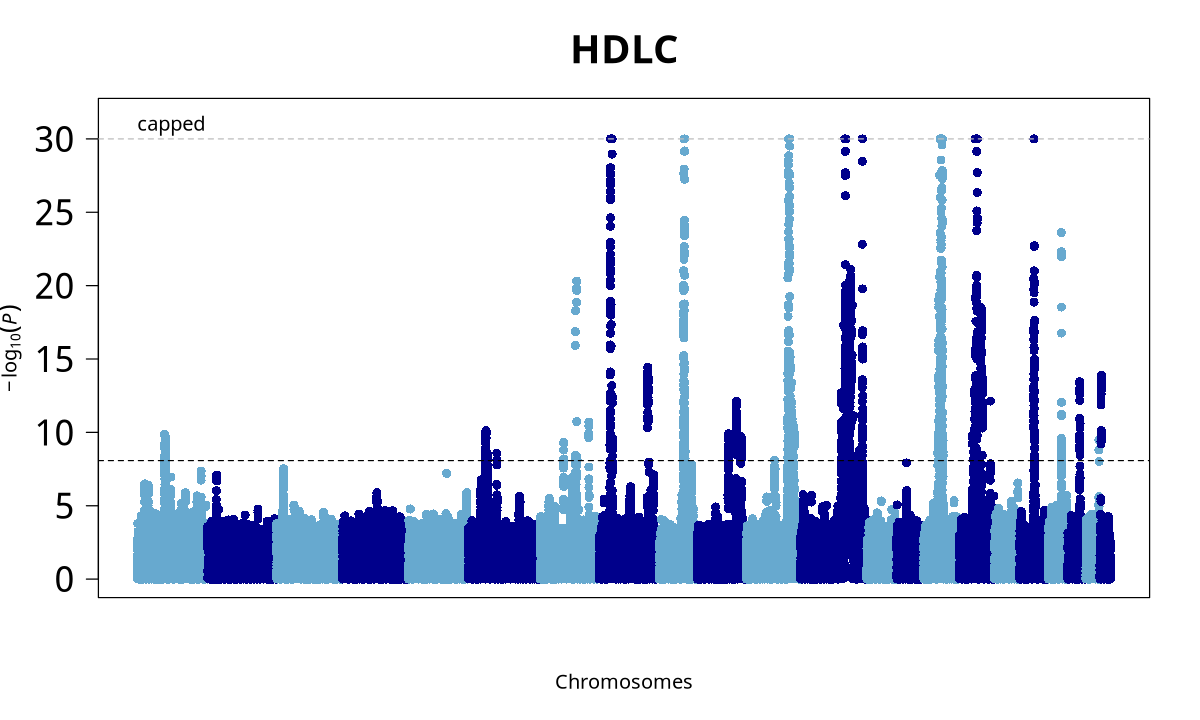

In [61]:
manPlot(data$P,chr=as.integer(data$CHR),cap = 10^-30,main="HDLC")


 - how many chromsomes have at least one genome wide significant SNP?

inflaction factors (GC)= 1.141686

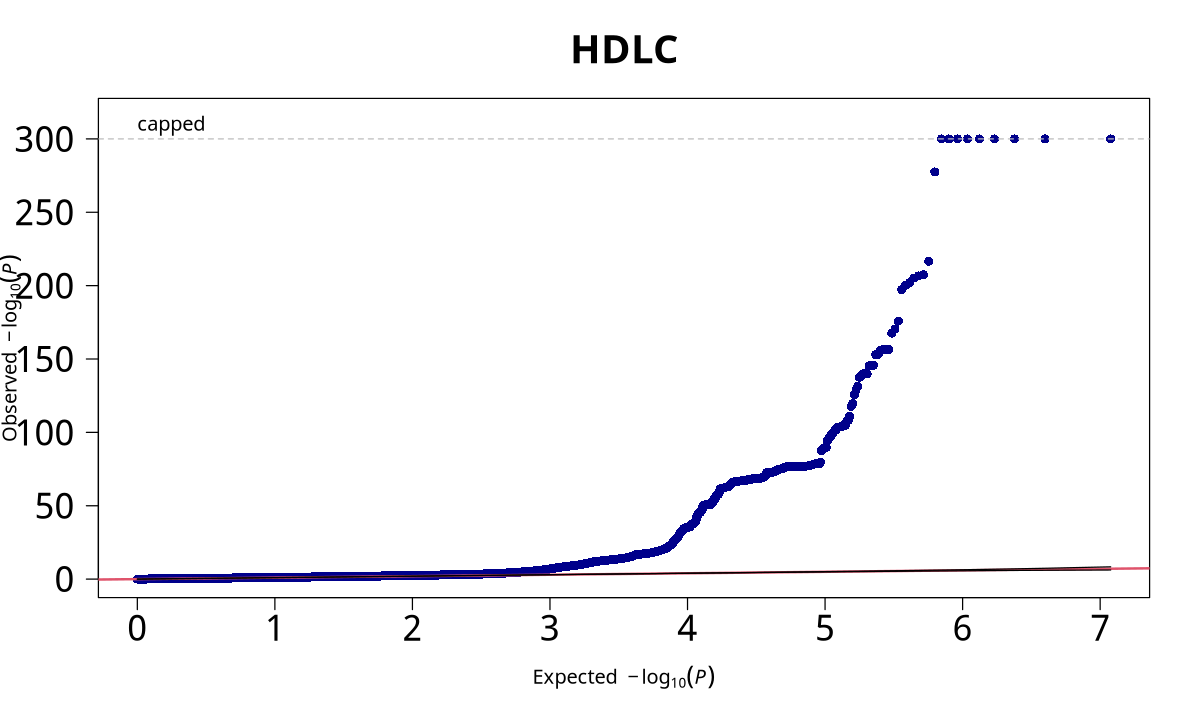

In [62]:


qqPlot(data$P,cap=1e-300,main="HDLC")

#calculate the inflation factors
X2 <- qchisq(data$P,lower=FALSE,df=1)
lambda <- median(X2)/qchisq(0.5,df=1)
cat("inflaction factors (GC)=",lambda)


 - How does the QQ plot look? Anything we should be worried about?
 - Try to change the cap option above in order to better see the shape of the QQ plot. e.g. cap=1e-30.
 - What does the inflation factor indicate

Lets also see the qq plot for LDLC

In [63]:

dataLDL <- fread("./BBJ_LDLC.txt.gz", sep="\t", header=TRUE, stringsAsFactors=FALSE, data.table=FALSE)


inflaction factors (GC)= 1.075238

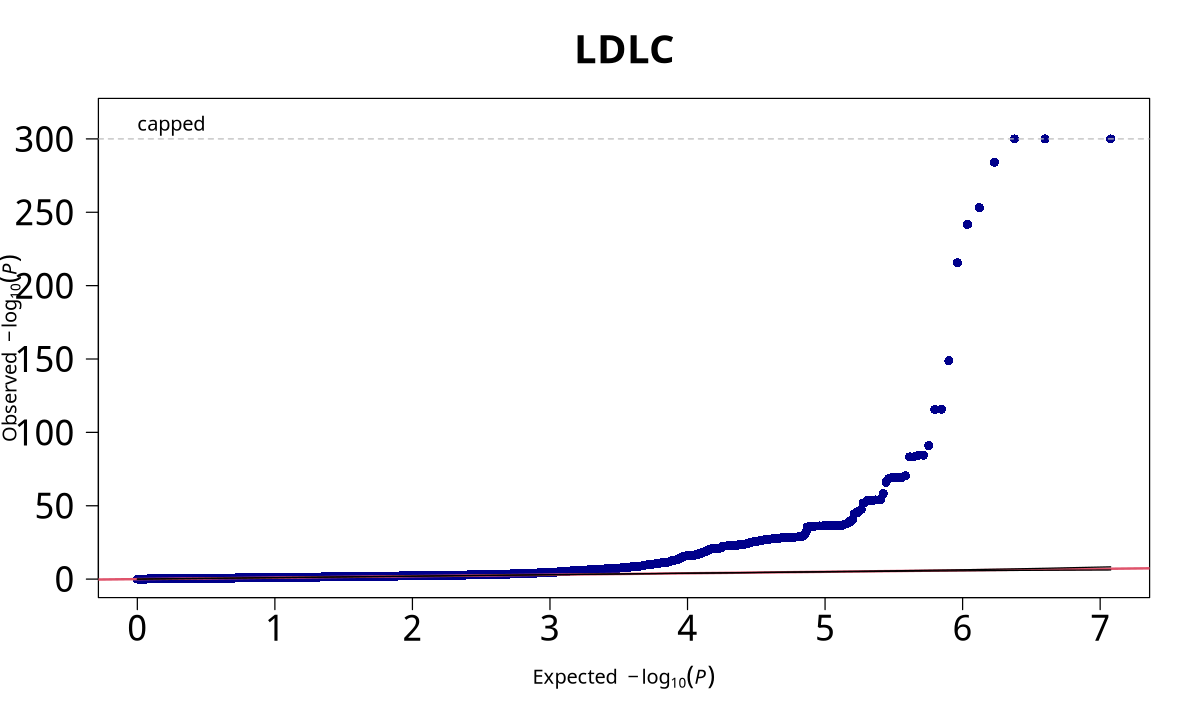

In [64]:

qqPlot(dataLDL$P,cap=1e-300,main="LDLC")

#calculate the inflation factors
X2 <- qchisq(dataLDL$P,lower=FALSE,df=1)
lambda <- median(X2)/qchisq(0.5,df=1)
cat("inflaction factors (GC)=",lambda)


 - Is LDL cholesterol p-valus inflated?
 
 To understand whether any inflation is due to confounding such as population structure or if it due to a trait being very polygenetic we can perform LD score regression

### Step 1: Munge sumstats

Before the LD score regression analysis, we need to format and clean the raw GWAS summery statistics. We also need to merge the data with the pre-calulated LD measuments. 

In [65]:

#takes around 1 min
${LDSC_MUNGE} \
    --sumstats ./BBJ_HDLC.txt.gz \
    --merge-alleles ./w_hm3.snplist \
    --a1 ALT \
    --a2 REF \
    --chunksize 500000 \
    --out BBJ_HDLC



(anders) *********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./munge_sumstats.py \
--out BBJ_HDLC \
--merge-alleles ./w_hm3.snplist \
--chunksize 500000 \
--a1 ALT \
--a2 REF \
--sumstats ./BBJ_HDLC.txt.gz 

Interpreting column names as follows:
BETA:	[linear/logistic] regression coefficient (0 --> no effect; above 0 --> A1 is trait/risk increasing)
N:	Sample size
P:	p-Value
Frq:	Allele frequency
SNP:	Variant ID (e.g., rs number)
ALT:	Allele 1, interpreted as ref allele for signed sumstat.
REF:	Allele 2, interpreted as non-ref allele for signed sumstat.

Reading list of SNPs for allele merge from ./w_hm3.snplist
Read 1217311 SNPs for allele merge.
Reading sumstats from ./BBJ_HDLC.txt.gz into

 - How many SNPs were merged with the pre calculated LD measurements?
 - The inflation factor (Lambda GC) is slightly different then what we calculated in R. why? 
 

Lets also run the merging for LDLC

In [66]:

${LDSC_MUNGE} \
    --sumstats ./BBJ_LDLC.txt.gz \
    --merge-alleles w_hm3.snplist \
    --a1 ALT \
    --a2 REF \
    --chunksize 500000 \
    --out BBJ_LDLC


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./munge_sumstats.py \
--out BBJ_LDLC \
--merge-alleles w_hm3.snplist \
--chunksize 500000 \
--a1 ALT \
--a2 REF \
--sumstats ./BBJ_LDLC.txt.gz 

Interpreting column names as follows:
BETA:	[linear/logistic] regression coefficient (0 --> no effect; above 0 --> A1 is trait/risk increasing)
N:	Sample size
P:	p-Value
Frq:	Allele frequency
SNP:	Variant ID (e.g., rs number)
ALT:	Allele 1, interpreted as ref allele for signed sumstat.
REF:	Allele 2, interpreted as non-ref allele for signed sumstat.

Reading list of SNPs for allele merge from w_hm3.snplist
Read 1217311 SNPs for allele merge.
Reading sumstats from ./BBJ_LDLC.txt.gz into memory 50000

In [67]:

zcat BBJ_HDLC.sumstats.gz | head -n2
zcat BBJ_LDLC.sumstats.gz | head -n2


SNP	A2	A1	Z	N
rs3094315	G	A	-0.726	70657.000

gzip: stdout: Broken pipe
(anders) SNP	A2	A1	Z	N
rs3094315	G	A	-1.442	72866.000

gzip: stdout: Broken pipe
(anders) 


In [68]:

zcat BBJ_HDLC.sumstats.gz | wc -l
zcat BBJ_LDLC.sumstats.gz | wc -l


1217312
(anders) 1217312
(anders) 


### LD score regression

Univariate LD score regression is utilized to estimate heritbility 
and confuding factors (cryptic relateness and population stratification)
 of a certain trait.

 Reference : Bulik-Sullivan, Brendan K., et al. "LD Score regression 
distinguishes confounding from polygenicity in genome-wide association 
studies." Nature genetics 47.3 (2015): 291-295.


Using the munged sumstats, we can run the LD score regression:

In [69]:

${LDSC} \
  --h2 BBJ_HDLC.sumstats.gz \
  --ref-ld-chr eas_ldscores/ \
  --w-ld-chr eas_ldscores/ \
  --out BBJ_HDLC


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2 BBJ_HDLC.sumstats.gz \
--ref-ld-chr eas_ldscores/ \
--out BBJ_HDLC \
--w-ld-chr eas_ldscores/ 

Beginning analysis at Fri Jul 25 10:25:28 2025
Reading summary statistics from BBJ_HDLC.sumstats.gz ...
Read summary statistics for 1020377 SNPs.
Reading reference panel LD Score from eas_ldscores/[1-22] ... (ldscore_fromlist)
Read reference panel LD Scores for 1208050 SNPs.
Removing partitioned LD Scores with zero variance.
Reading regression weight LD Score from eas_ldscores/[1-22] ... (ldscore_fromlist)
Read regression weight LD Scores for 1208050 SNPs.
After merging with reference panel LD, 1012040 SNPs remain.
After merging 

In [70]:

${LDSC} \
  --h2 BBJ_LDLC.sumstats.gz \
  --ref-ld-chr eas_ldscores/ \
  --w-ld-chr eas_ldscores/ \
  --out BBJ_LDLC


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2 BBJ_LDLC.sumstats.gz \
--ref-ld-chr eas_ldscores/ \
--out BBJ_LDLC \
--w-ld-chr eas_ldscores/ 

Beginning analysis at Fri Jul 25 10:25:38 2025
Reading summary statistics from BBJ_LDLC.sumstats.gz ...
Read summary statistics for 1020377 SNPs.
Reading reference panel LD Score from eas_ldscores/[1-22] ... (ldscore_fromlist)
Read reference panel LD Scores for 1208050 SNPs.
Removing partitioned LD Scores with zero variance.
Reading regression weight LD Score from eas_ldscores/[1-22] ... (ldscore_fromlist)
Read regression weight LD Scores for 1208050 SNPs.
After merging with reference panel LD, 1012040 SNPs remain.
After merging 

In [71]:

cat BBJ_HDLC.log


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2 BBJ_HDLC.sumstats.gz \
--ref-ld-chr eas_ldscores/ \
--out BBJ_HDLC \
--w-ld-chr eas_ldscores/ 

Beginning analysis at Fri Jul 25 10:25:28 2025
Reading summary statistics from BBJ_HDLC.sumstats.gz ...
Read summary statistics for 1020377 SNPs.
Reading reference panel LD Score from eas_ldscores/[1-22] ... (ldscore_fromlist)
Read reference panel LD Scores for 1208050 SNPs.
Removing partitioned LD Scores with zero variance.
Reading regression weight LD Score from eas_ldscores/[1-22] ... (ldscore_fromlist)
Read regression weight LD Scores for 1208050 SNPs.
After merging with reference panel LD, 1012040 SNPs remain.
After merging 

In [72]:

cat BBJ_LDLC.log


*********************************************************************
* LD Score Regression (LDSC)
* Version 1.0.1
* (C) 2014-2019 Brendan Bulik-Sullivan and Hilary Finucane
* Broad Institute of MIT and Harvard / MIT Department of Mathematics
* GNU General Public License v3
*********************************************************************
Call: 
./ldsc.py \
--h2 BBJ_LDLC.sumstats.gz \
--ref-ld-chr eas_ldscores/ \
--out BBJ_LDLC \
--w-ld-chr eas_ldscores/ 

Beginning analysis at Fri Jul 25 10:25:38 2025
Reading summary statistics from BBJ_LDLC.sumstats.gz ...
Read summary statistics for 1020377 SNPs.
Reading reference panel LD Score from eas_ldscores/[1-22] ... (ldscore_fromlist)
Read reference panel LD Scores for 1208050 SNPs.
Removing partitioned LD Scores with zero variance.
Reading regression weight LD Score from eas_ldscores/[1-22] ... (ldscore_fromlist)
Read regression weight LD Scores for 1208050 SNPs.
After merging with reference panel LD, 1012040 SNPs remain.
After merging 


We can see that from the log:
 - Observed scale h2 = 0.1583
 - lambda GC = 1.1523
 - intercept = 1.0563
 - Ratio = 0.1981

The ratio measures the proportion of the inflation in the mean chi^2 that the LD Score regression that is explained by causes other than polygenic heritability i.e. confounding. The value of ratio
 should be close to zero, though in practice values of 10-20% are not uncommon.
